## This notebook contains data standardization and various machine learning models, including a GridSearch to programatically try differnent hyperparameters

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Need to specify fips as str to prevent losing leading 0s
health = pd.read_csv("./datasets/all_health_data_final.csv", dtype={"fips":str}).drop("Unnamed: 0", axis = 1)
income = pd.read_csv("./datasets/county_income_final.csv", dtype={"fips":str}).drop("Unnamed: 0", axis = 1)

%matplotlib inline

In [9]:
health[health["fips"] == "11001"]

,fips,MHLTH,HIGHCHOL,LPA,PHLTH,CANCER,DENTAL,COPD,OBESITY,STROKE,...,CASTHMA,BINGE,CHD,BPMED,ARTHRITIS,KIDNEY,BPHIGH,DIABETES,SLEEP,CSMOKING
484,11001,11.780899,31.491573,21.475281,10.730899,5.15,67.076966,5.28764,26.36236,3.389888,...,10.371348,21.256742,4.371348,73.407865,19.858427,2.724157,30.154494,9.587079,36.208427,19.527528


In [10]:
health.shape, income.shape

((485, 22), (3141, 8))

In [11]:
df = pd.merge(income, health, how="inner",on="fips")

In [12]:
#We lose a large portion of the fips codes, as they do not have income data
# There is still a lot of data wrapped up in these 41 rows, as they are aggregations to the county level
# Getting more precise income data would allow us to keep more rows

df.shape

(42, 29)

In [14]:
df.head()

,County-equivalent,State,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds,fips,MHLTH,HIGHCHOL,...,CASTHMA,BINGE,CHD,BPMED,ARTHRITIS,KIDNEY,BPHIGH,DIABETES,SLEEP,CSMOKING
0,Washington City,District of Columbia,45290.0,65830.0,79665.0,"619,371","263,649",11001,11.780899,31.491573,...,10.371348,21.256742,4.371348,73.407865,19.858427,2.724157,30.154494,9.587079,36.208427,19.527528
1,Travis,Texas,33206.0,58025.0,73951.0,"1,063,248","411,876",48453,12.108000,39.256000,...,7.584000,13.284000,6.724000,75.280000,20.408000,3.520000,31.604000,15.088000,31.620000,13.528000
2,Ventura,California,32930.0,76544.0,86301.0,"829,017","267,076",06111,9.170000,33.040000,...,7.565000,18.725000,4.945000,71.205000,20.510000,2.475000,26.725000,7.085000,30.865000,9.865000
3,Santa Cruz,California,32295.0,66519.0,80899.0,"264,808","93,504",06087,11.388889,34.083333,...,7.616667,15.600000,4.700000,69.538889,16.083333,2.333333,25.933333,9.638889,33.966667,12.983333
4,Honolulu,Hawaii,30361.0,72764.0,85440.0,"964,678","309,803",15003,9.096154,35.210256,...,8.834615,18.745726,4.325214,72.929487,17.733761,2.583333,31.272222,9.134615,47.248718,14.173077


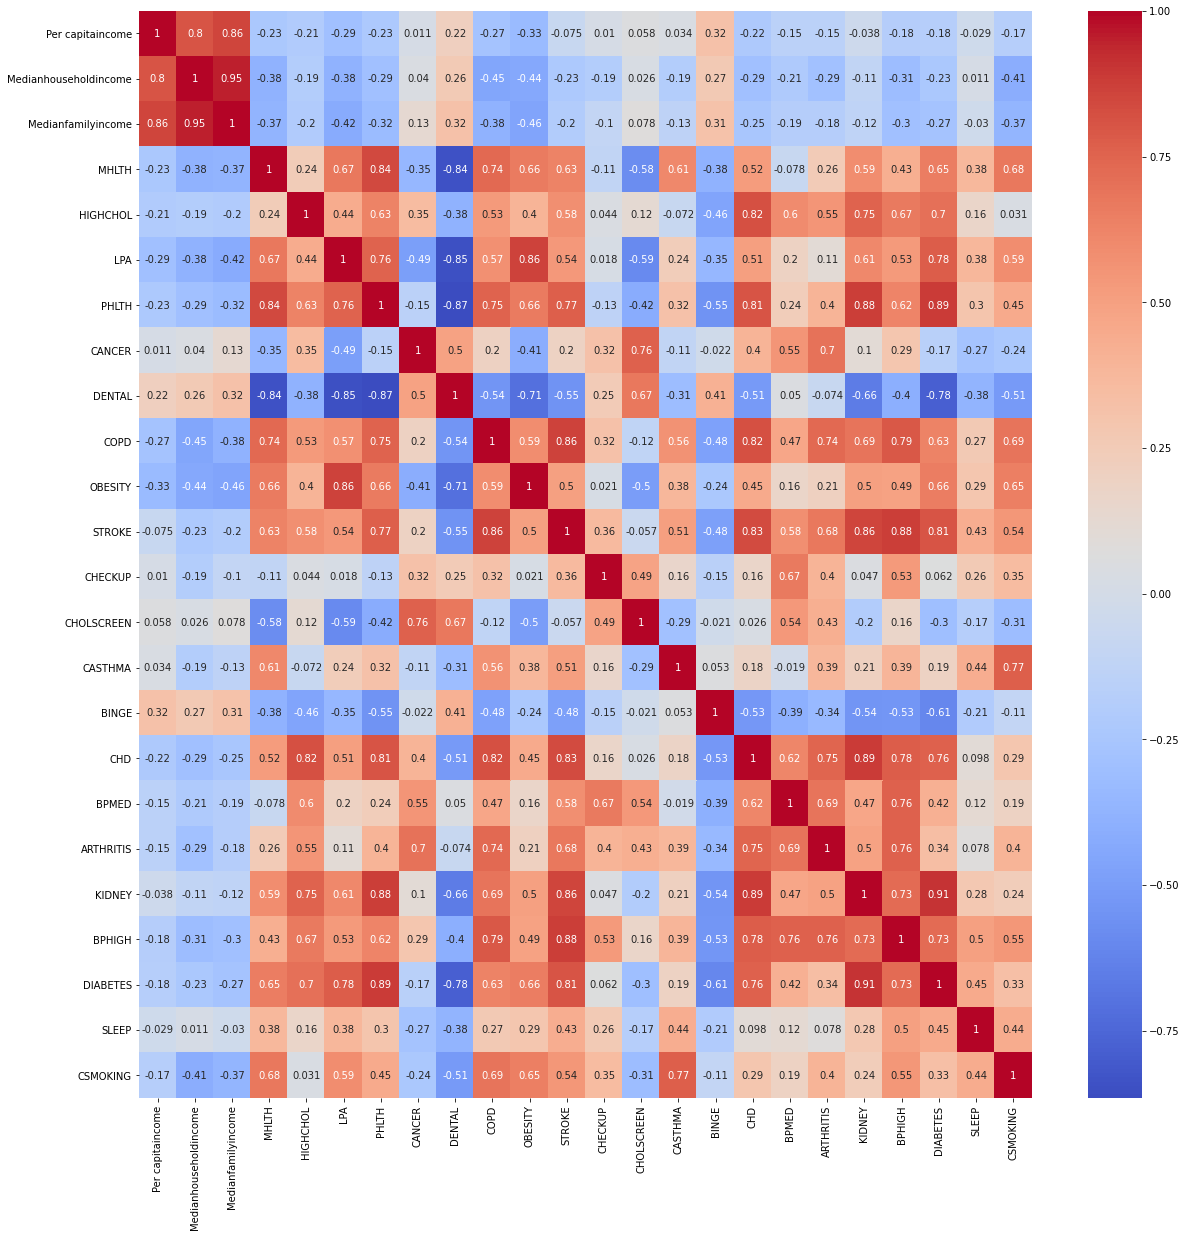

In [15]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.corr(), annot = True, ax= ax, cmap="coolwarm")
### looking at correlation between variables and per capita income

In [250]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LassoCV

In [251]:
df.columns

Index(['County-equivalent', 'State', 'Per capitaincome',
       'Medianhouseholdincome', 'Medianfamilyincome', 'Population',
       'Number ofhouseholds', 'fips', 'MHLTH', 'HIGHCHOL', 'LPA', 'PHLTH',
       'CANCER', 'DENTAL', 'COPD', 'OBESITY', 'STROKE', 'CHECKUP',
       'CHOLSCREEN', 'CASTHMA', 'BINGE', 'CHD', 'BPMED', 'ARTHRITIS', 'KIDNEY',
       'BPHIGH', 'DIABETES', 'SLEEP', 'CSMOKING'],
      dtype='object')

In [381]:
X = df[['COPD', 'CHOLSCREEN', 'KIDNEY', 'BINGE', 'CHECKUP',
       'PHLTH', 'OBESITY', 'ARTHRITIS', 'CASTHMA', 'DENTAL', 'SLEEP', 'CANCER',
       'LPA', 'BPHIGH', 'DIABETES', 'STROKE', 'BPMED', 'CSMOKING', 'MHLTH',
       'CHD']] ## features for modeling
# X = df[["MHLTH", "SLEEP", "BINGE", "CHECKUP", "BPHIGH", "LPA"]]
y = df['Per capitaincome'] ## target for modeling

In [382]:
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X,y) #train test split

In [383]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test) # scale the features with scaler fit on training data

In [384]:
baseline_prediction_val = np.mean(y_train)
baseline_predictions = np.array([baseline_prediction_val for i in range(len(y_test))])

In [385]:
baseline_mse = mean_squared_error(y_test, baseline_predictions) ** .5

In [386]:
baseline_mse

3352.0502723526583

## Simple Linear Regression

In [387]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest

In [388]:
### originally used select K best, but model performed best using all features

In [389]:
lr = LinearRegression()
model = lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
mean_squared_error(y_test, preds) ** .5

9041.265707689607

In [390]:
np.std(model.coef_), np.mean(model.coef_) # used these values to create a standardized importance for the features below

(8178.730296282377, -238.36551522494156)

In [391]:
coefs = pd.DataFrame({"features":X_train.columns, "coef": model.coef_})

In [392]:
coefs["importance"] = [(x-110.101)/1758.232 for x in coefs.coef]

In [393]:
coefs.sort_values("importance", ascending=False).set_index("features", drop = True) # dataframe of feature importance

,coef,importance
features,,
COPD,15347.377402,8.666249
DIABETES,13948.249819,7.870491
KIDNEY,9263.346943,5.205938
CSMOKING,9124.947630,5.127222
BINGE,7163.631062,4.011717
ARTHRITIS,5097.932170,2.836845
CHOLSCREEN,708.240542,0.340194
BPHIGH,468.794206,0.204008
CHECKUP,101.322490,-0.004993


## Random Forest With Gridsearch

In [394]:
rf = RandomForestRegressor()
params = {"n_estimators":[3,7,10,12,15],
         "max_depth":[None,7,5,3],
         "min_samples_split":[2,3,4],
         "min_samples_leaf":[1,2],
         "n_jobs":[4]}

In [395]:
gs = GridSearchCV(estimator=rf, param_grid=params)

In [396]:
gs.fit(X_train_scaled,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 7, 5, 3],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [3, 7, 10, 12, 15], 'n_jobs': [4]})

In [397]:
gs.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15,
 'n_jobs': 4}

In [398]:
preds = gs.predict(X_test_scaled)

In [399]:
mean_squared_error(y_test, preds) ** .5

3251.595590408097

## Lasso

In [402]:
las = LassoCV(n_jobs=4, max_iter=15000)
las.fit(X_train_scaled, y_train)
preds = las.predict(X_test_scaled)
mean_squared_error(y_test, preds)** .5

3318.987283814797